In [1]:
import os
import sys
sys.path.append("..")
import dnnlib
import legacy
import pickle
import torch

import PIL.Image as Image
from training.camera_utils import *
import math
from notebook_utils import *

import numpy as np
import glob
import random

## Load the Checkpoints

In [57]:
device = "cuda"

# StyleGAN 2
model_path = "/share/phoenix/nfs04/S7/emc348/stylegan3/training-runs/00322-raycond2-cars_train-gpus2-batch32-gamma0.3/network-snapshot-015120.pkl"

#StyleGAN 3T
#model_path = "/share/phoenix/nfs04/S7/emc348/stylegan3/training-runs/00323-raycond3-t-cars_train-gpus4-batch32-gamma0.5/network-snapshot-003840.pkl"


In [58]:
with open(model_path, 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda().eval()

## Initialize the Camera Parameters

In [55]:
cam_pivot = torch.tensor([0., 0., 0.], device=device)
cam_radius = 1.3
focal_length = 1.7074
intrinsics = torch.tensor([[focal_length, 0, 0.5], [0, focal_length, 0.5], [0, 0, 1]], device=device) # Intrinsics are resolution invariant

c2w = UniformBlenderPoseSampler.sample_upper_hemi(radius=cam_radius, device=device)
c = torch.cat([c2w.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)

## Sample an Image

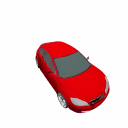

In [59]:
torch.manual_seed(0)
z = torch.randn([1, G.z_dim]).cuda() # Latent Code
with torch.no_grad():
    img = G(z, c, truncation_psi=0.7)[0]
tensor2im(img)

## Sample More Camera Poses

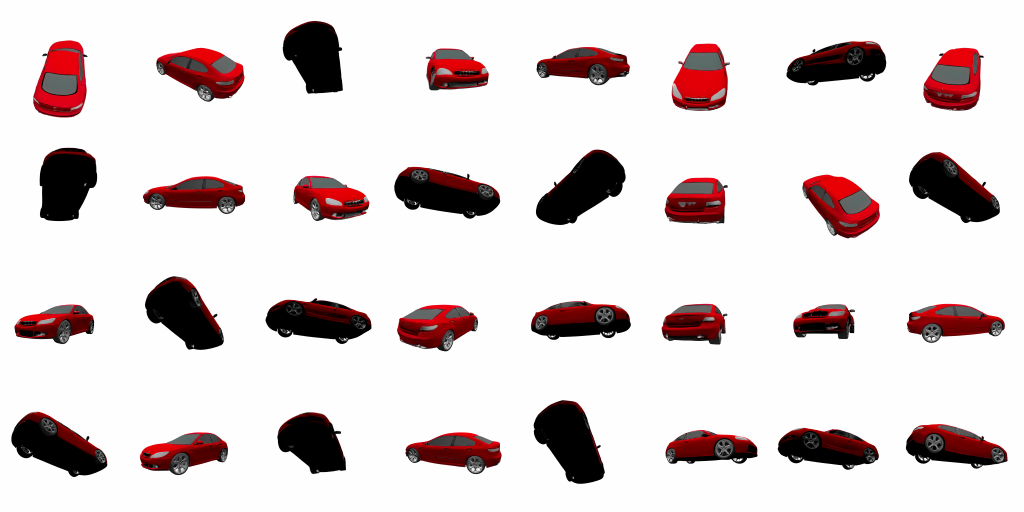

In [64]:
imgs = []
for _ in range(32):
    c2w = UniformBlenderPoseSampler.sample_upper_hemi(radius=cam_radius, device=device)
    c = torch.cat([c2w.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)

    with torch.no_grad():
        img = G(z, c, truncation_psi=0.7)[0]
    imgs.append(tensor2im(img))
image_grid(imgs, 4, 8)